In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

data = pd.read_csv('close_prices.csv')

In [2]:
smoothed_data = pd.read_csv('smoothed_close_prices.csv')

In [3]:
# Δημιουργία καθυστερημένων τιμών (lags) για τη στήλη 'Smoothed Close Price'
for lag in range(1, 5):  # Δημιουργία 4 καθυστερημένων τιμών
    smoothed_data[f'smoothed_close_t-{lag}'] = smoothed_data['Smoothed Close Price'].shift(-lag)

smoothed_data.fillna(0, inplace=True)

smoothed_data.tail()

,Date,Close Price,Smoothed Close Price,smoothed_close_t-1,smoothed_close_t-2,smoothed_close_t-3,smoothed_close_t-4
6294,05-11-99,88.31,86.871965,86.238859,85.706621,85.321221,85.118641
6295,04-11-99,83.62,86.238859,85.706621,85.321221,85.118641,0.000000
6296,03-11-99,81.50,85.706621,85.321221,85.118641,0.000000,0.000000
6297,02-11-99,80.25,85.321221,85.118641,0.000000,0.000000,0.000000
6298,01-11-99,77.62,85.118641,0.000000,0.000000,0.000000,0.000000


In [4]:
smoothed_data.head()

,Date,Close Price,Smoothed Close Price,smoothed_close_t-1,smoothed_close_t-2,smoothed_close_t-3,smoothed_close_t-4
0,12-11-24,224.23,225.188819,225.257761,225.399496,225.620585,225.927674
1,11-11-24,224.23,225.257761,225.399496,225.620585,225.927674,226.324445
2,08-11-24,226.96,225.399496,225.620585,225.927674,226.324445,226.808956
3,07-11-24,227.48,225.620585,225.927674,226.324445,226.808956,227.371733
4,06-11-24,222.72,225.927674,226.324445,226.808956,227.371733,227.994912


In [5]:
smoothed_data['Date'] = pd.to_datetime(data['Date'])

# Χωρίζουμε τα δεδομένα σε εκπαίδευση και επικύρωση
validation_data = smoothed_data[smoothed_data['Date'].dt.year == 2024]  # Στοιχεία για επικύρωση (2024)
training_data = smoothed_data[smoothed_data['Date'].dt.year < 2024]     # Στοιχεία για εκπαίδευση (προηγούμενα έτη)

# Ορισμός χαρακτηριστικών και στόχου
X_train = training_data[['smoothed_close_t-1', 'smoothed_close_t-2', 'smoothed_close_t-3', 'smoothed_close_t-4']]
y_train = training_data['Smoothed Close Price']

X_val = validation_data[['smoothed_close_t-1', 'smoothed_close_t-2', 'smoothed_close_t-3', 'smoothed_close_t-4']]
y_val = validation_data['Smoothed Close Price']

# Δημιουργία του μοντέλου γραμμικής παλινδρόμησης και εκπαίδευση
model = LinearRegression()
model.fit(X_train, y_train)

C:\Users\evage\AppData\Local\Temp\ipykernel_13872\2250476378.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  smoothed_data['Date'] = pd.to_datetime(data['Date'])


LinearRegression()

In [6]:
# Πρόβλεψη στο σύνολο εκπαίδευσης 
y_pred_train = model.predict(X_train)

# Προβλεψη στο σύνολο επικύρωσης
predictions = model.predict(X_val)

In [7]:
# Υπολογισμός των μετρικών
mse_train = mean_squared_error(y_train, y_pred_train)
mse_val = mean_squared_error(y_val, predictions)
mae_train = mean_absolute_error(y_train, y_pred_train)
mae_val = mean_absolute_error(y_val, predictions)

print("Training MSE:", mse_train)
print("Validation MSE:", mse_val)
print("Training MAE:", mae_train)
print("Validation MAE:", mae_val)

Training MSE: 1.8644965128824296
Validation MSE: 0.029046793335067714
Training MAE: 0.2296081930188999
Validation MAE: 0.13774907819400298


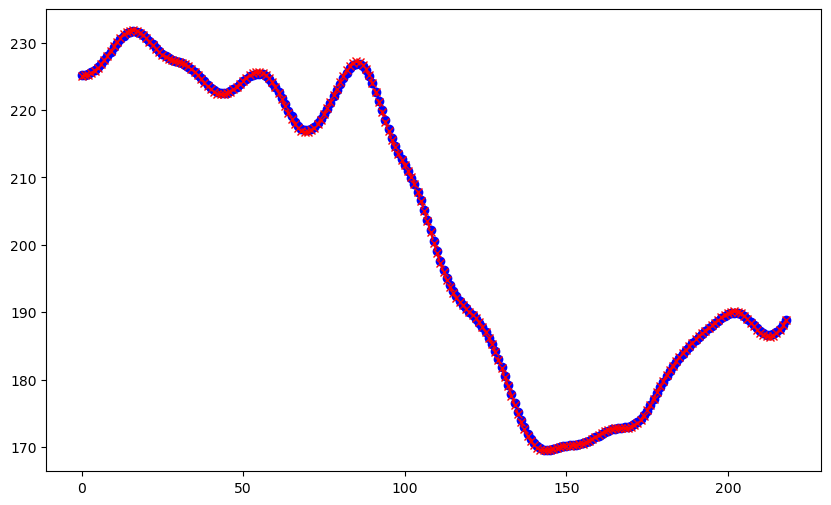

In [8]:
import matplotlib.pyplot as plt

# Γραφική απεικόνιση με πραγματικές και προβλεπόμενες τιμές στο σύνολο επικύρωσης
plt.figure(figsize=(10, 6))
plt.plot(y_val.reset_index(drop=True), label='Actual Values', color='blue', marker='o')
plt.plot(predictions, label='Predicted Values', color='red', linestyle='--', marker='x')

## Prediction

In [9]:
# παίρνουμε τις 4 τε΄λευταίεσ closing prices 
last_3_prices = smoothed_data['Smoothed Close Price'].head(4).values  

if len(last_3_prices) >= 4:
    features = last_3_prices[-4:]  
else:
    raise ValueError("Not enough data to create features for prediction.")

# προετοιμασία των features για prediction 
X_next = pd.DataFrame([features], columns=['smoothed_close_t-1', 'smoothed_close_t-2', 'smoothed_close_t-3', 'smoothed_close_t-4'])

# πρόβλεψη closing τιμής της επόμενης ημέρας
predicted_price = model.predict(X_next)

# Αποτέλεσμα πρόβλεψης
print(f"Predicted Close Price for next day: {predicted_price[0]}")

Predicted Close Price for next day: 225.06401697235597


## Ridge & Lasso

In [10]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Lasso, Ridge

# Πολυωνυμικά χαρακτηριστικά 
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)
X_val_poly = poly.transform(X_val)

# Υπερπαράμετροι για L1 (Lasso) και L2 (Ridge) κανονικοποίηση
alpha_l1 = 0.1  # Για το Lasso
alpha_l2 = 0.1 # Για το Ridge

# Μοντέλο Lasso (L1 κανονικοποίηση)
lasso = Lasso(alpha=alpha_l1, max_iter=10000)
lasso.fit(X_train_poly, y_train)
predictions_train_lasso = lasso.predict(X_train_poly)
predictions_val_lasso = lasso.predict(X_val_poly)

# Μοντέλο Ridge (L2 κανονικοποίηση)
ridge = Ridge(alpha=alpha_l2)
ridge.fit(X_train_poly, y_train)
predictions_train_ridge = ridge.predict(X_train_poly)
predictions_val_ridge = ridge.predict(X_val_poly)

# Υπολογισμός μετρικών σφάλματος για το Lasso και το Ridge
# Lasso
mse_train_lasso = mean_squared_error(y_train, predictions_train_lasso)
mae_train_lasso = mean_absolute_error(y_train, predictions_train_lasso)

mse_val_lasso = mean_squared_error(y_val, predictions_val_lasso)
mae_val_lasso = mean_absolute_error(y_val, predictions_val_lasso)

# Ridge
mse_train_ridge = mean_squared_error(y_train, predictions_train_ridge)
mae_train_ridge = mean_absolute_error(y_train, predictions_train_ridge)

mse_val_ridge = mean_squared_error(y_val, predictions_val_ridge)
mae_val_ridge = mean_absolute_error(y_val, predictions_val_ridge)

# Εκτύπωση των μετρικών σφάλματος και παραμέτρων
print("Lasso (L1) Regression Metrics:")
print(f"Training MSE: {mse_train_lasso}, MAE: {mae_train_lasso}")
print(f"Validation MSE: {mse_val_lasso}, MAE: {mae_val_lasso}")

print("\nRidge (L2) Regression Metrics:")
print(f"Training MSE: {mse_train_ridge}, MAE: {mae_train_ridge}")
print(f"Validation MSE: {mse_val_ridge}, MAE: {mae_val_ridge}")

Lasso (L1) Regression Metrics:
Training MSE: 1.7009307771458815, MAE: 0.3353379426229136
Validation MSE: 0.09352570480573304, MAE: 0.25360177604002077

Ridge (L2) Regression Metrics:
Training MSE: 1.1910124647219895, MAE: 0.043154104750206396
Validation MSE: 0.0003519685324040286, MAE: 0.015269404206967636
